<a href="https://colab.research.google.com/github/mandalanil/Semi-Automated-workflow-for-flood-risk-mapping/blob/main/SpatioTemporal_GCN_GRU_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--- STEP 1: LOADING AND PREPROCESSING DATA ---
Error: Static features file not found at /content/drive/MyDrive/Final_Model_Data/STATIC_FEATURES.csv.
Detected 5 HUCS (nodes).
--- STEP 2: CREATING EVENT SAMPLES AND COMBINED FEATURES ---
Identified 151 total event start days across all HUCs.
Extracted 151 total 3-day (144-step) event samples.
--- STEP 3: SCALING STATISTICS AND DATA TRANSFORMATION ---
Final Input (X) shape: (151, 144, 5, 15)
Final Target (y) shape: (151, 144, 5)
--- STEP 4: CREATING NORMALIZED ADJACENCY MATRIX (A_norm) ---
Graph loaded with 5 nodes and 4 edges.
A_norm matrix shape: (5, 5)
--- STEP 5: SPLITTING DATA (80/20) ---
Training Samples: 120, Testing Samples: 31

--- STEP 6: BUILDING GCN-GRU MODEL ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 144, 5, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gcn_layer (GCNLayer)            │ (None, 144, 5, 32)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (Reshape)       │ (None, 144, 160)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer (GRU)                 │ (None, 144, 64)        │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 144, 5)         │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,197 (172.64 KB)

 Trainable params: 44,197 (172.64 KB)

 Non-trainable params: 0 (0.00 B)


--- STEP 7: STARTING MODEL TRAINING ---
Epoch 1/50
4/4 - 12s - 3s/step - loss: 0.8716 - mae: 0.6420 - val_loss: 0.8756 - val_mae: 0.5548
Epoch 2/50
4/4 - 1s - 199ms/step - loss: 0.6170 - mae: 0.5147 - val_loss: 0.6695 - val_mae: 0.4824
Epoch 3/50
4/4 - 1s - 319ms/step - loss: 0.5110 - mae: 0.4890 - val_loss: 0.5241 - val_mae: 0.4505
Epoch 4/50
4/4 - 1s - 193ms/step - loss: 0.4178 - mae: 0.4554 - val_loss: 0.4073 - val_mae: 0.4093
Epoch 5/50
4/4 - 1s - 189ms/step - loss: 0.3395 - mae: 0.4147 - val_loss: 0.2987 - val_mae: 0.3557
Epoch 6/50
4/4 - 1s - 188ms/step - loss: 0.2665 - mae: 0.3661 - val_loss: 0.2025 - val_mae: 0.2933
Epoch 7/50
4/4 - 1s - 184ms/step - loss: 0.2114 - mae: 0.3271 - val_loss: 0.1304 - val_mae: 0.2435
Epoch 8/50
4/4 - 1s - 190ms/step - loss: 0.1742 - mae: 0.2991 - val_loss: 0.0841 - val_mae: 0.2041
Epoch 9/50
4/4 - 1s - 188ms/step - loss: 0.1548 - mae: 0.2846 - val_loss: 0.0615 - val_mae: 0.1797
Epoch 10/50
4/4 - 1s - 312ms/step - loss: 0.1428 - mae: 0.2750 - val_l

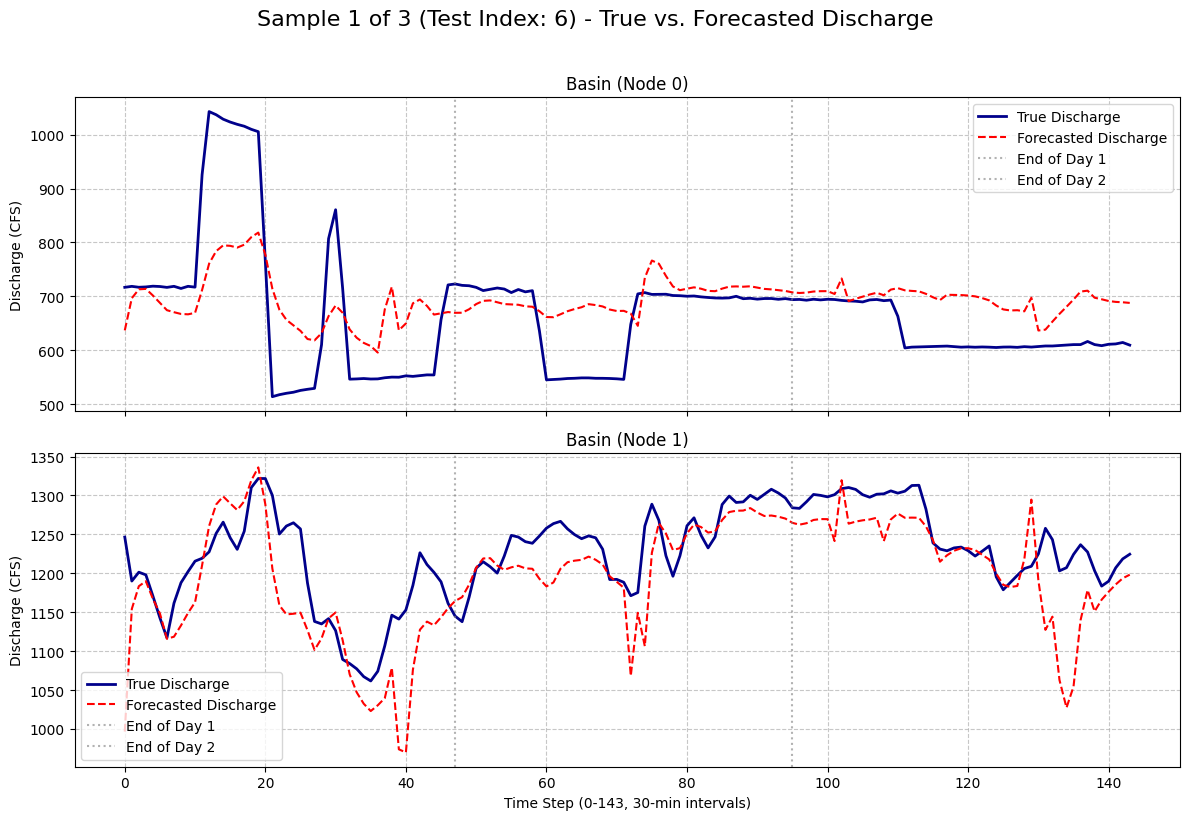

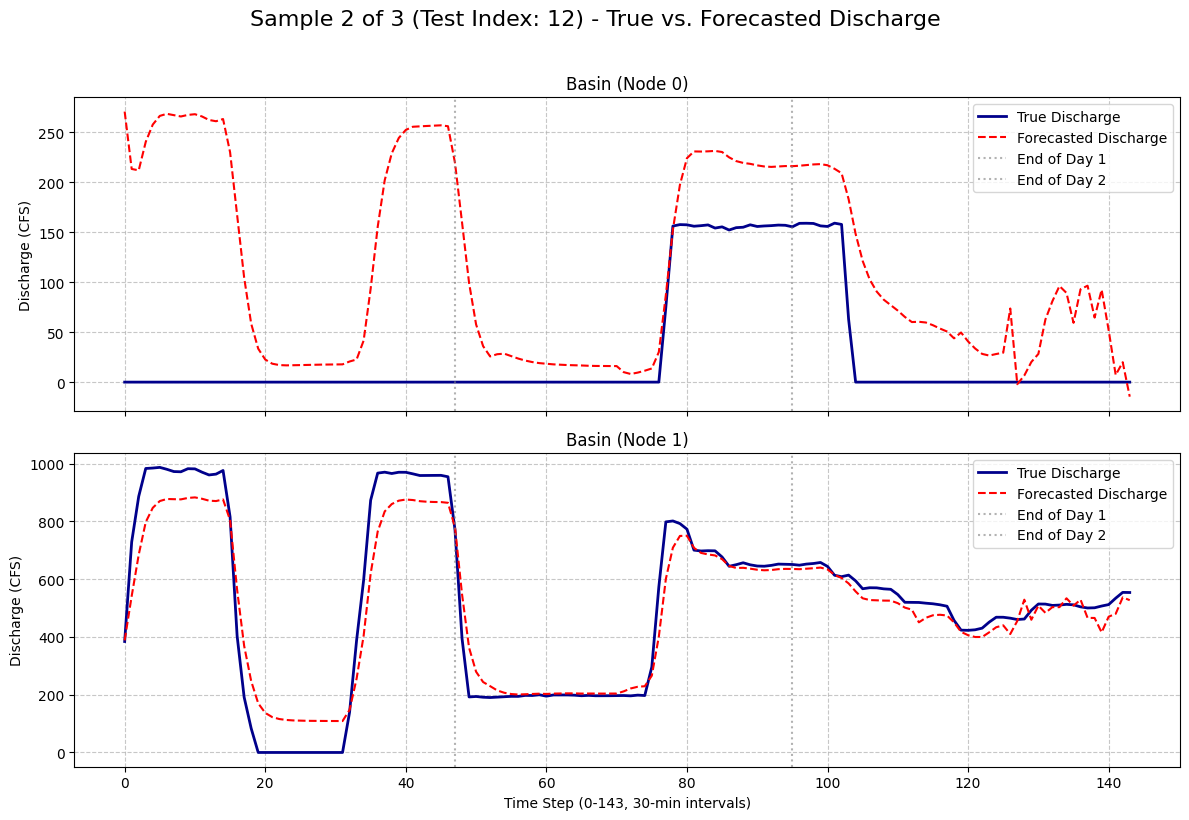

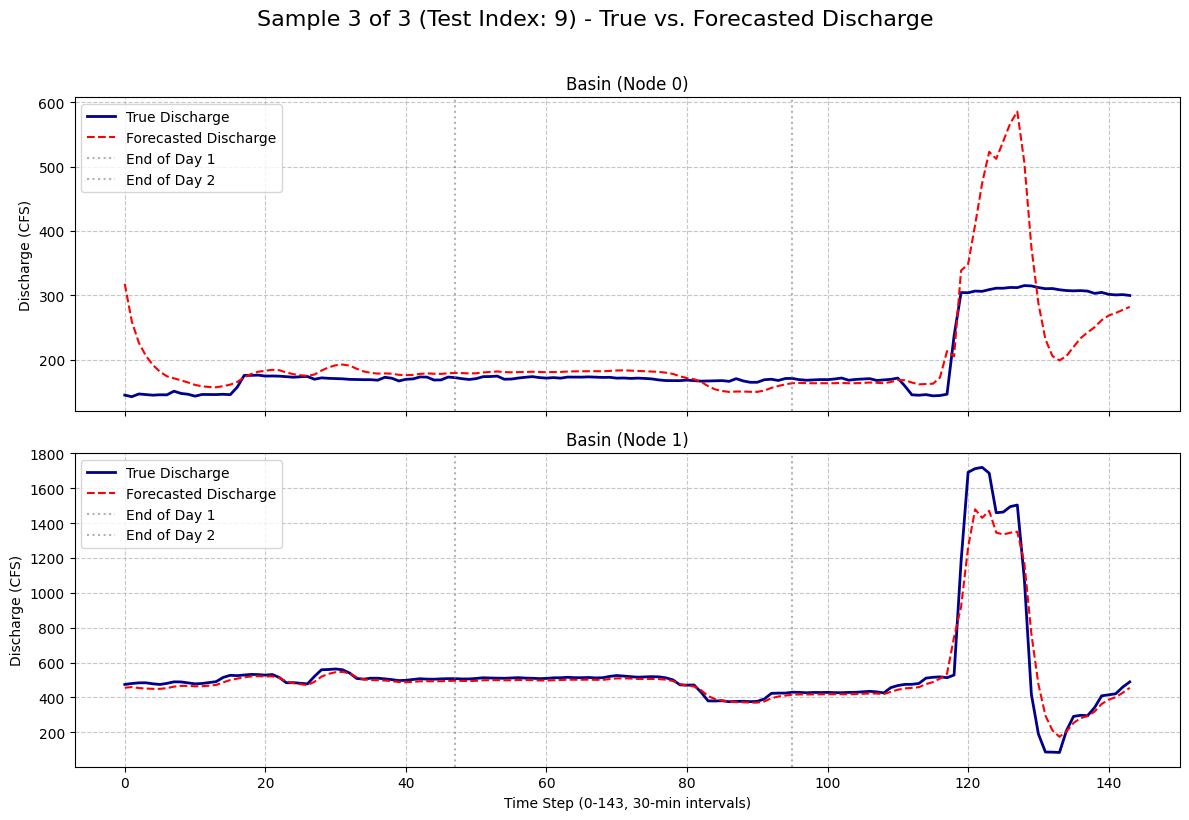

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from typing import Tuple
import random
import matplotlib.pyplot as plt

# --- GLOBAL PATHS AND PARAMETERS ---
# NOTE: Update these paths to match your Google Drive setup if necessary
BASE_PATH = '/content/drive/MyDrive/Final_Model_Data/'
GRAPH_FILE_PATH = BASE_PATH + 'HUC_Flow_Network_Directed.json'
STATIC_FEATURES_FILENAME = 'STATIC_FEATURES.csv' # <<< ASSUMED STATIC FEATURES FILENAME
TIME_SERIES_FILENAMES = [
    '030901012102_TIMESERIES_30MIN.csv',
    '030901030401_TIMESERIES_30MIN.csv',
    '030901030402_TIMESERIES_30MIN.csv',
    '030901012003_TIMESERIES_30MIN.csv',
    '030901012101_TIMESERIES_30MIN.csv'
]

# Model and Event Configuration
HORIZON_DAYS = 3
STEPS_PER_DAY = 48  # 24 hours * 2 (30-minute intervals)
EVENT_WINDOW_STEPS = HORIZON_DAYS * STEPS_PER_DAY  # 144
RAIN_THRESHOLD = 0.5  # inches
DRY_DAYS_THRESHOLD = 1
GCN_OUTPUT_DIM = 32
GRU_UNITS = 64
DROPOUT_RATE = 0.3
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 10
NUM_SAMPLES_TO_PLOT = 3 # Number of random test samples to visualize

# --- GLOBAL GRAPH PLACEHOLDER ---
# This variable will be set after A_norm is calculated and accessed by the GCNLayer.
A_norm_global = None

# =========================================================================
# I. DATA PREPARATION FUNCTIONS
# =========================================================================

def load_all_timeseries(base_path, filenames):
    """Loads and preprocesses all 30-min time series data."""
    all_timeseries_list = []

    def load_and_preprocess_timeseries(filepath):
        try:
            temp_df = pd.read_csv(filepath)
            if temp_df.empty: return pd.DataFrame()

            temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
            temp_df = temp_df.set_index('Timestamp')

            huc12 = filepath.split('/')[-1].split('_')[0]
            temp_df['HUC12'] = huc12
            return temp_df[['HUC12', 'CFS', 'Inches']]
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
            return pd.DataFrame()

    for filename in filenames:
        full_path = base_path + filename
        temp_df = load_and_preprocess_timeseries(full_path)
        if not temp_df.empty:
            all_timeseries_list.append(temp_df)

    if not all_timeseries_list:
        raise FileNotFoundError("No time series data loaded.")

    df = pd.concat(all_timeseries_list)
    df.index.name = 'Timestamp'

    # Handle missing values
    df['CFS'] = df.groupby('HUC12')['CFS'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df['Inches'] = df.groupby('HUC12')['Inches'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df.dropna(inplace=True)

    # Pivot to create discharge and rainfall matrices
    df.sort_index(inplace=True)
    discharge_matrix = df.pivot(columns='HUC12', values='CFS')
    rainfall_matrix = df.pivot(columns='HUC12', values='Inches')

    return discharge_matrix, rainfall_matrix

def load_real_static_features(base_path, filename, expected_huc_ids):
    """
    Loads real static features from a CSV file, sets the HUC column as index,
    and ensures the index aligns with the time series HUCs.
    """
    filepath = base_path + filename
    try:
        static_df = pd.read_csv(filepath)

        # Assume the HUC identifier column is named 'HUC12'
        if 'HUC12' not in static_df.columns:
            raise ValueError("Static features file must contain a 'HUC12' column.")

        static_df = static_df.set_index('HUC12')

        # Select only the HUCs that are present in the time series data (expected_huc_ids)
        static_features_df = static_df.loc[expected_huc_ids].copy()

        # Drop non-numeric columns, but keep HUC12 as index
        numeric_cols = static_features_df.select_dtypes(include=np.number).columns
        static_features_df = static_features_df[numeric_cols]

        print(f"Successfully loaded {len(static_features_df)} static feature rows and {len(numeric_cols)} features.")
        return static_features_df

    except FileNotFoundError:
        print(f"Error: Static features file not found at {filepath}.")
        # Fallback to dummy data if the real file is missing
        return create_dummy_static_features(expected_huc_ids)
    except KeyError as e:
        print(f"Error: Mismatch between time series HUCs and static data HUCs. Missing HUC ID: {e}")
        # Fallback if HUC IDs don't match, though this should be fixed for real training
        return create_dummy_static_features(expected_huc_ids)
    except ValueError as e:
        print(f"Error: {e}")
        return create_dummy_static_features(expected_huc_ids)


def create_dummy_static_features(huc_ids):
    """Creates a dummy static features DataFrame for demonstration."""
    print("Warning: Static features file not found or invalid. Creating DUMMY static features.")

    # These feature names are based on your original plan
    feature_names = [
        'Min_Elevation_m', 'Max_Elevation_m', 'Mean_Elevation_m', 'Median_Elevation_m',
        'Std_Dev_Elevation_m', 'Min_Slope_deg', 'Max_Slope_deg', 'Mean_Slope_deg',
        'Median_Slope_deg', 'Std_Dev_Slope_deg', 'Composite_CN', 'Area_ha', 'Dummy_Feature_1'
    ]

    data = {}
    for name in feature_names:
        # Ensure the seed is within the valid range for numpy.random.seed
        seed_value = (42 + name.__hash__()) % (2**32 - 1)
        np.random.seed(seed_value)
        data[name] = np.round(np.random.rand(len(huc_ids)) * 100, 2)

    static_features_df = pd.DataFrame(data, index=huc_ids)
    return static_features_df

def identify_and_extract_events(discharge_matrix, rainfall_matrix, static_features_df):
    """Identifies event start times and extracts 30-min event windows."""

    # 1. Daily Aggregation for Event Identification
    daily_rainfall_df = rainfall_matrix.resample('D').sum()
    rainfall_3day_sum = daily_rainfall_df.rolling(window=HORIZON_DAYS, min_periods=HORIZON_DAYS).sum()
    is_dry = (daily_rainfall_df == 0)

    dry_period_ending_before_event = is_dry.rolling(window=DRY_DAYS_THRESHOLD, min_periods=DRY_DAYS_THRESHOLD).apply(lambda x: np.prod(x), raw=True)

    # 2. Identify Event Start Days
    sum_threshold_met_at_end_day = (rainfall_3day_sum >= RAIN_THRESHOLD)
    sum_met_aligned_to_start = sum_threshold_met_at_end_day.shift(- (HORIZON_DAYS - 1) )
    dry_period_met_aligned_to_start = dry_period_ending_before_event.shift(1)

    event_start_mask = (sum_met_aligned_to_start == True) & (dry_period_met_aligned_to_start == True)
    event_start_mask = event_start_mask.fillna(False)

    print(f"Identified {event_start_mask.sum().sum()} total event start days across all HUCs.")

    # 3. Extract 30-Minute Event Samples
    event_samples = []
    static_features_array = static_features_df.values
    num_static_features = static_features_df.shape[1]

    for huc_id in event_start_mask.columns:
        for time_index, row in event_start_mask.iterrows():
            if row[huc_id]:
                event_start_time_30min = pd.to_datetime(time_index.strftime('%Y-%m-%d 00:00:00'))
                event_end_time_30min = event_start_time_30min + pd.Timedelta(minutes=(EVENT_WINDOW_STEPS - 1) * 30)

                if event_end_time_30min > rainfall_matrix.index.max(): continue

                try:
                    rainfall_window = rainfall_matrix.loc[event_start_time_30min:event_end_time_30min].values
                    discharge_window = discharge_matrix.loc[event_start_time_30min:event_end_time_30min].values
                except KeyError:
                    continue

                if len(rainfall_window) != EVENT_WINDOW_STEPS: continue

                # Stack dynamic features: (T, N, 2)
                dynamic_stacked = np.stack([discharge_window, rainfall_window], axis=-1)

                # Repeat static features: (T, N, N_static_features)
                static_repeated = np.tile(static_features_array[np.newaxis, :, :], (EVENT_WINDOW_STEPS, 1, 1))

                # Combined features: (T, N, 2 + N_static_features)
                combined_features = np.concatenate([dynamic_stacked, static_repeated], axis=-1)

                event_samples.append({
                    'event_huc_id': huc_id,
                    'rainfall_data': rainfall_window,
                    'discharge_data': discharge_window,
                    'combined_features': combined_features
                })

    return event_samples, num_static_features

def calculate_scaling_stats(discharge_matrix, rainfall_matrix, static_features_df):
    """Calculates scaling statistics from the full dataset."""
    num_timesteps_30min = discharge_matrix.shape[0]
    num_static_features = static_features_df.shape[1]
    total_features = 2 + num_static_features

    # 1. Create full combined feature array
    static_full = np.tile(static_features_df.values[np.newaxis,:,:], (num_timesteps_30min, 1, 1))
    dynamic_stacked_full = np.stack([discharge_matrix.values, rainfall_matrix.values], axis=-1)
    combined_full = np.concatenate([dynamic_stacked_full, static_full], axis=-1)

    # 2. Reshape for mean/std calculation: (Timesteps * Nodes, Total_Features)
    reshaped_full = combined_full.reshape(-1, total_features)

    # 3. Calculate mean and std
    mean_stats = np.mean(reshaped_full, axis=0)
    std_stats = np.std(reshaped_full, axis=0)

    # Handle zero std to avoid division by zero
    std_stats[std_stats == 0] = 1e-8

    return mean_stats, std_stats, total_features

def scale_event_samples(event_samples, mean_stats, std_stats, total_features):
    """Scales all event samples using the calculated statistics."""
    X_list = []
    y_list = []

    # Index 0 is Discharge (the target feature)
    discharge_mean = mean_stats[0]
    discharge_std = std_stats[0]

    for sample in event_samples:
        combined_features = sample['combined_features']
        discharge_target = sample['discharge_data']

        # Scale X (Input features)
        reshaped_X = combined_features.reshape(-1, total_features)
        scaled_X = (reshaped_X - mean_stats) / std_stats
        scaled_X = scaled_X.reshape(combined_features.shape)
        X_list.append(scaled_X)

        # Scale y (Target discharge)
        reshaped_y = discharge_target.reshape(-1, 1)
        scaled_y = (reshaped_y - discharge_mean) / discharge_std
        scaled_y = scaled_y.reshape(discharge_target.shape)
        y_list.append(scaled_y)

    X_events = np.array(X_list, dtype=np.float32)
    y_events = np.array(y_list, dtype=np.float32)

    return X_events, y_events

def create_normalized_adjacency_matrix(huc_ids, graph_file_path):
    """Loads graph data and calculates the Normalized Adjacency Matrix (A_norm)."""

    G = nx.DiGraph()
    try:
        with open(graph_file_path, 'r') as f:
            graph_data = json.load(f)

        if 'links' in graph_data:
            for link in graph_data['links']:
                source, target = str(link['source']), str(link['target'])
                if source in huc_ids and target in huc_ids:
                    G.add_edge(source, target)

        # Ensure all HUCs are in the graph
        for huc_id in huc_ids:
             if huc_id not in G.nodes:
                 G.add_node(huc_id)

    except Exception as e:
        print(f"Error loading graph file: {e}")
        print("Using an identity matrix as a fallback for A_norm (no connectivity learned).")
        return np.eye(len(huc_ids), dtype=np.float32)

    # 2. Get Adjacency Matrix (A) in the correct HUC order
    A = nx.adjacency_matrix(G, nodelist=huc_ids, dtype=np.float32).todense()
    A = np.array(A)

    # 3. Add Self-loops (A_hat = A + I)
    I = np.eye(A.shape[0], dtype=np.float32)
    A_hat = A + I

    # 4. Calculate Degree Matrix (D_hat)
    degrees_hat = np.array(A_hat.sum(axis=1)).flatten()
    D_hat_inv_sqrt = np.zeros_like(A_hat)

    # Handle zero degrees
    non_zero_degrees_hat_indices = np.where(degrees_hat != 0)[0]
    D_hat_inv_sqrt[non_zero_degrees_hat_indices, non_zero_degrees_hat_indices] = 1.0 / np.sqrt(degrees_hat[non_zero_degrees_hat_indices])

    # 5. Calculate Normalized Adjacency Matrix (A_norm)
    A_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"A_norm matrix shape: {A_norm.shape}")

    return A_norm

# =========================================================================
# II. GCN-GRU MODEL DEFINITIONS
# =========================================================================

class GCNLayer(tf.keras.layers.Layer):
    """
    Graph Convolutional Layer: H' = A_norm * H * W
    Input shape: (batch_size, time_steps, num_nodes, feature_dim)
    """
    def __init__(self, output_dim, activation='relu', **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.output_dim),
                                      initializer='glorot_uniform',
                                      name='kernel')
        super(GCNLayer, self).build(input_shape)

    def call(self, inputs):
        # Access the globally set A_norm matrix
        # NOTE: A_norm_global must be set in the main execution block before model building.
        A_norm_tensor = tf.constant(A_norm_global, dtype=tf.float32)

        # 1. Reshape for batch processing: (batch*time, num_nodes, feature_dim)
        H = tf.reshape(inputs, (-1, tf.shape(inputs)[-2], tf.shape(inputs)[-1]))

        # 2. H * W (Feature transformation)
        H_W = tf.einsum('ijk,kp->ijp', H, self.kernel)

        # 3. A_norm * (H * W) (Spatial aggregation/Graph Convolution)
        A_H_W = tf.einsum('ij,bjk->bik', A_norm_tensor, H_W)

        # 4. Reshape back to (batch_size, time_steps, num_nodes, output_dim)
        output = tf.reshape(A_H_W, (tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[-2], self.output_dim))
        return self.activation(output)

def build_gcn_gru_model(
    input_shape: Tuple,
    num_nodes: int,
    output_steps: int,
    gcn_output_dim: int = GCN_OUTPUT_DIM,
    gru_units: int = GRU_UNITS,
    dropout_rate: float = DROPOUT_RATE
) -> Model:
    """Defines the true Spatio-Temporal GCN-GRU model."""

    event_input = Input(shape=input_shape, name='event_input')

    # 1. Spatial Feature Extraction (GCN)
    gcn_out = GCNLayer(output_dim=gcn_output_dim, activation='relu', name='gcn_layer')(event_input)

    # 2. Reshape for Temporal Layer (GRU)
    reshaped_for_rnn = Reshape(
        (output_steps, num_nodes * gcn_output_dim),
        name='reshape_for_rnn'
    )(gcn_out)

    # 3. Temporal Modeling (GRU)
    gru_out = GRU(
        units=gru_units,
        activation='relu',
        return_sequences=True,
        name='gru_layer'
    )(reshaped_for_rnn)

    gru_out = Dropout(dropout_rate, name='dropout')(gru_out)

    # 4. Output Layer
    output_dense = TimeDistributed(
        Dense(num_nodes, name='output_dense'),
        name='time_distributed_output'
    )(gru_out)

    model = Model(inputs=event_input, outputs=output_dense)
    return model

# =========================================================================
# III. MAIN EXECUTION BLOCK (Training and Evaluation)
# =========================================================================

if __name__ == '__main__':

    # 1. RUN DATA PREPARATION
    print("--- STEP 1: LOADING AND PREPROCESSING DATA ---")
    try:
        discharge_matrix, rainfall_matrix = load_all_timeseries(BASE_PATH, TIME_SERIES_FILENAMES)
    except FileNotFoundError as e:
        print(f"FATAL ERROR: {e}")
        exit()

    huc_ids = discharge_matrix.columns.tolist()
    num_nodes = len(huc_ids)

    # <<< MODIFIED SECTION: Load real static features instead of calling the dummy function
    static_features_df = load_real_static_features(BASE_PATH, STATIC_FEATURES_FILENAME, huc_ids)
    # >>> END MODIFIED SECTION

    print(f"Detected {num_nodes} HUCS (nodes).")

    print("--- STEP 2: CREATING EVENT SAMPLES AND COMBINED FEATURES ---")
    event_samples, num_static_features = identify_and_extract_events(discharge_matrix, rainfall_matrix, static_features_df)
    print(f"Extracted {len(event_samples)} total 3-day (144-step) event samples.")

    print("--- STEP 3: SCALING STATISTICS AND DATA TRANSFORMATION ---")
    mean_stats, std_stats, total_features = calculate_scaling_stats(discharge_matrix, rainfall_matrix, static_features_df)
    X_events, y_events = scale_event_samples(event_samples, mean_stats, std_stats, total_features)

    print(f"Final Input (X) shape: {X_events.shape}")
    print(f"Final Target (y) shape: {y_events.shape}")

    print("--- STEP 4: CREATING NORMALIZED ADJACENCY MATRIX (A_norm) ---")
    A_norm = create_normalized_adjacency_matrix(huc_ids, GRAPH_FILE_PATH)

    # CRITICAL: SET THE GLOBAL A_NORM VARIABLE FOR THE GCNLAYER
    global A_norm_global
    A_norm_global = A_norm

    # 5. SPLIT DATA (80/20)
    print("--- STEP 5: SPLITTING DATA (80/20) ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X_events, y_events, test_size=0.2, random_state=42
    )
    print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

    # 6. BUILD MODEL
    print("\n--- STEP 6: BUILDING GCN-GRU MODEL ---")
    input_shape = (EVENT_WINDOW_STEPS, num_nodes, total_features)
    gcn_gru_model = build_gcn_gru_model(
        input_shape=input_shape,
        num_nodes=num_nodes,
        output_steps=EVENT_WINDOW_STEPS
    )

    # 7. COMPILE MODEL
    gcn_gru_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    gcn_gru_model.summary()

    # 8. TRAIN MODEL
    print("\n--- STEP 7: STARTING MODEL TRAINING ---")
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    history = gcn_gru_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset,
        callbacks=[early_stopping],
        verbose=2
    )
    print("\nModel training complete.")

    # 9. EVALUATION
    print("\n--- STEP 8: MODEL EVALUATION ---")

    y_pred_events = gcn_gru_model.predict(X_test)

    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred_events.flatten()

    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"R-squared (R^2) on the Test Set: {r2:.4f}")

    # Unscale for visualization
    discharge_mean = mean_stats[0]
    discharge_std = std_stats[0]
    y_true_unscaled_all = y_test * discharge_std + discharge_mean
    y_pred_unscaled_all = y_pred_events * discharge_std + discharge_mean

    # 10. VISUALIZATION: MULTIPLE SAMPLES AND BASINS
    print(f"\n--- STEP 9: VISUALIZING {NUM_SAMPLES_TO_PLOT} RANDOM TEST SAMPLES ---")

    test_sample_indices = random.sample(range(X_test.shape[0]), min(NUM_SAMPLES_TO_PLOT, X_test.shape[0]))

    # We will plot Node 0 and Node 1 for visual comparison across samples.
    nodes_to_plot = [0, 1]

    for i, sample_index in enumerate(test_sample_indices):

        fig, axes = plt.subplots(len(nodes_to_plot), 1, figsize=(12, 4 * len(nodes_to_plot)), sharex=True)
        fig.suptitle(f'Sample {i+1} of {len(test_sample_indices)} (Test Index: {sample_index}) - True vs. Forecasted Discharge', fontsize=16, y=1.02)

        for j, node_index in enumerate(nodes_to_plot):

            ax = axes[j] if len(nodes_to_plot) > 1 else axes

            # Plot True (Actual) Discharge
            ax.plot(y_true_unscaled_all[sample_index, :, node_index],
                    label='True Discharge', color='darkblue', linewidth=2)

            # Plot Predicted (Forecasted) Discharge
            ax.plot(y_pred_unscaled_all[sample_index, :, node_index],
                    label='Forecasted Discharge', color='red', linestyle='--', linewidth=1.5)

            # Day markers
            ax.axvline(x=47, color='grey', linestyle=':', alpha=0.6, label='End of Day 1')
            ax.axvline(x=95, color='grey', linestyle=':', alpha=0.6, label='End of Day 2')

            ax.set_title(f'Basin (Node {node_index})')
            ax.set_ylabel('Discharge (CFS)')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)

        ax.set_xlabel('Time Step (0-143, 30-min intervals)')
        plt.tight_layout()
        plt.show()

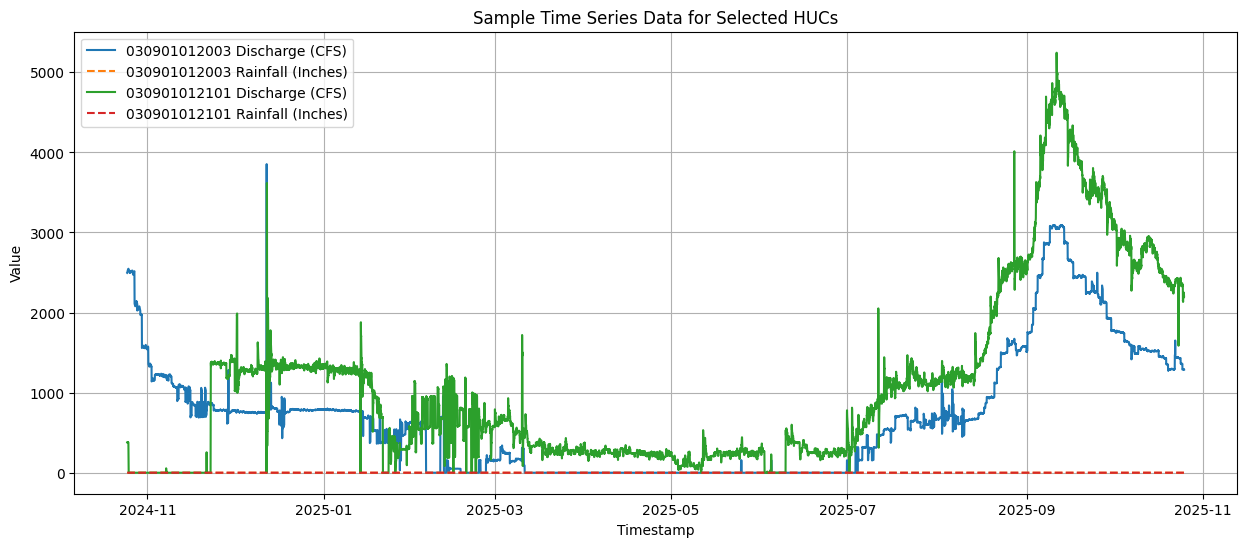


Sample Static Features:


,Min_Elevation_m,Max_Elevation_m,Mean_Elevation_m,Median_Elevation_m,Std_Dev_Elevation_m,Min_Slope_deg,Max_Slope_deg,Mean_Slope_deg,Median_Slope_deg,Std_Dev_Slope_deg,Composite_CN,Area_ha,Dummy_Feature_1
030901012003,96.36,19.67,6.24,26.77,37.29,15.18,20.32,56.54,35.70,72.07,73.72,71.19,25.90
030901012101,23.81,69.01,10.23,71.02,46.35,31.25,91.37,27.18,6.33,56.78,76.25,33.64,89.86
030901012102,24.30,9.30,98.72,27.61,3.75,86.79,2.87,3.60,35.81,25.55,21.17,23.39,52.09
030901030401,97.31,55.18,23.62,75.65,33.87,63.90,18.42,16.75,44.56,67.51,69.42,68.42,80.54
030901030402,19.15,92.64,22.24,15.16,22.72,86.10,63.11,95.68,72.41,1.74,94.24,72.82,82.27


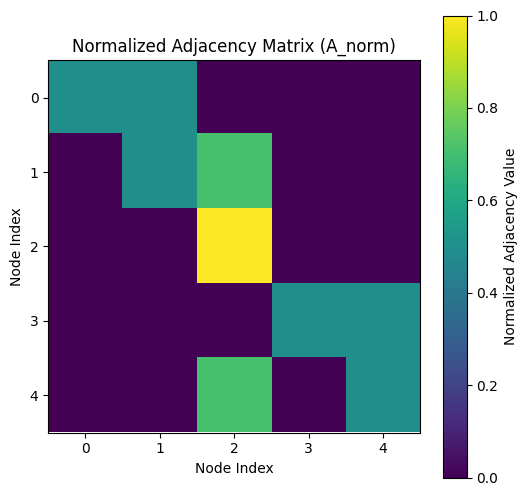

In [4]:
# Visualize Time Series Data
plt.figure(figsize=(15, 6))
for huc in discharge_matrix.columns[:2]: # Plotting first 2 HUCs for clarity
    plt.plot(discharge_matrix.index, discharge_matrix[huc], label=f'{huc} Discharge (CFS)')
    plt.plot(rainfall_matrix.index, rainfall_matrix[huc], label=f'{huc} Rainfall (Inches)', linestyle='--')
plt.title('Sample Time Series Data for Selected HUCs')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Static Features (first few rows)
print("\nSample Static Features:")
display(static_features_df.head())

# Visualize A_norm matrix (optional, for small graphs)
if num_nodes <= 10: # Only visualize for small graphs
    plt.figure(figsize=(6, 6))
    plt.imshow(A_norm_global, cmap='viridis', origin='upper')
    plt.colorbar(label='Normalized Adjacency Value')
    plt.title('Normalized Adjacency Matrix (A_norm)')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.show()
else:
    print("\nA_norm matrix visualization skipped for large graph.")

### Visualize Model Performance for a Specific Sample and Subset of Nodes

This plot shows the true and forecasted discharge for a chosen test sample, focusing on three specific basins to illustrate the model's performance at a finer granularity.

Visualizing Sample 0 for Nodes [0, 1, 2]


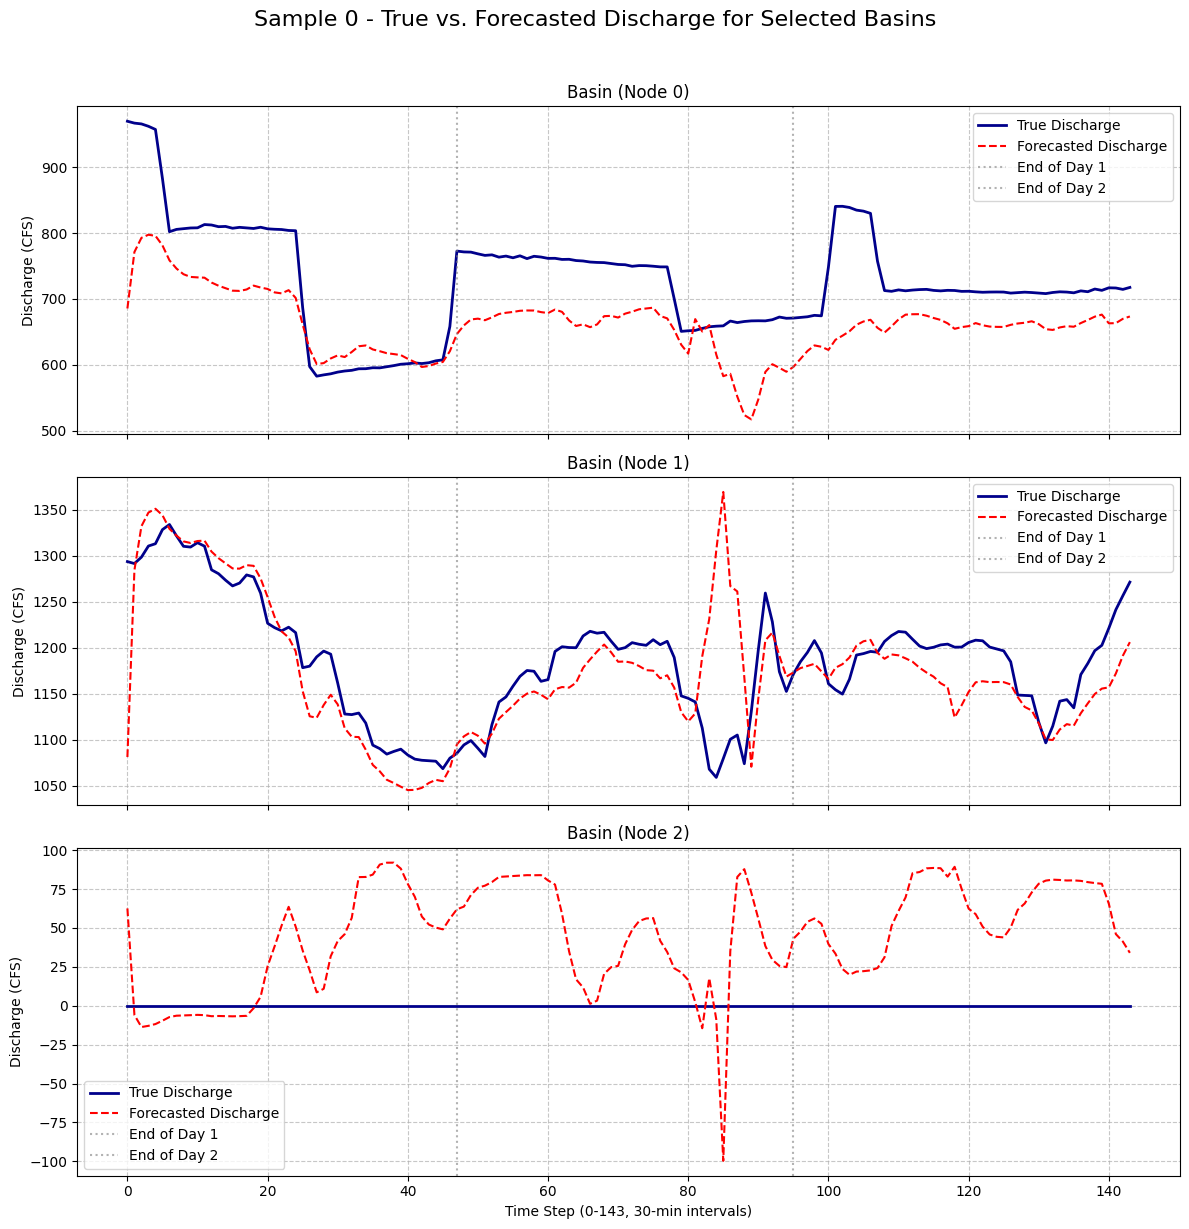

In [6]:
# Select a specific sample index (you can change this number)
specific_sample_index = 0 # For example, the first sample in the test set

# Select three specific node indices (you can change these numbers, must be < num_nodes)
specific_node_indices = [0, 1, 2] # For example, the first three nodes

if specific_sample_index >= X_test.shape[0]:
    print(f"Error: specific_sample_index ({specific_sample_index}) is out of bounds. Max index is {X_test.shape[0]-1}.")
elif any(node_index >= num_nodes for node_index in specific_node_indices):
     print(f"Error: One or more specific_node_indices ({specific_node_indices}) are out of bounds. Max node index is {num_nodes-1}.")
else:
    print(f"Visualizing Sample {specific_sample_index} for Nodes {specific_node_indices}")

    fig, axes = plt.subplots(len(specific_node_indices), 1, figsize=(12, 4 * len(specific_node_indices)), sharex=True)
    fig.suptitle(f'Sample {specific_sample_index} - True vs. Forecasted Discharge for Selected Basins', fontsize=16, y=1.02)

    # Unscale for visualization
    discharge_mean = mean_stats[0]
    discharge_std = std_stats[0]

    for i, node_index in enumerate(specific_node_indices):

        ax = axes[i] if len(specific_node_indices) > 1 else axes

        # Extract and unscale true and predicted discharge for the selected sample and node
        true_discharge_unscaled = y_test[specific_sample_index, :, node_index] * discharge_std + discharge_mean
        predicted_discharge_unscaled = y_pred_events[specific_sample_index, :, node_index] * discharge_std + discharge_mean

        # Plot True (Actual) Discharge
        ax.plot(true_discharge_unscaled,
                label='True Discharge', color='darkblue', linewidth=2)

        # Plot Predicted (Forecasted) Discharge
        ax.plot(predicted_discharge_unscaled,
                label='Forecasted Discharge', color='red', linestyle='--', linewidth=1.5)

        # Day markers
        ax.axvline(x=47, color='grey', linestyle=':', alpha=0.6, label='End of Day 1')
        ax.axvline(x=95, color='grey', linestyle=':', alpha=0.6, label='End of Day 2')

        ax.set_title(f'Basin (Node {node_index})')
        ax.set_ylabel('Discharge (CFS)')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

    ax.set_xlabel('Time Step (0-143, 30-min intervals)')
    plt.tight_layout()
    plt.show()

### Visualize Model Input and Output

This plot shows a sample event window provided as input to the model (specifically, the unscaled discharge and rainfall within that window for a chosen basin) and the corresponding discharge forecast produced by the model for the same basin and time window.

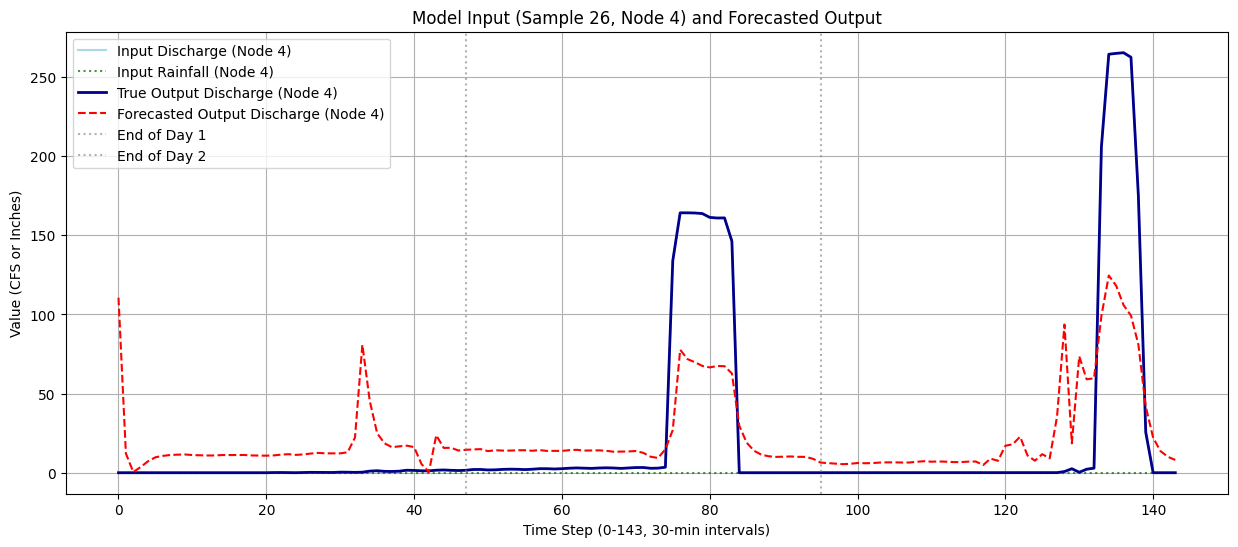

In [5]:
# Visualize Model Input (a sample event) and Output (forecast)
# Select a random sample from the test set
sample_index_to_plot = random.choice(range(X_test.shape[0]))
# Select a random node (basin) to plot
node_index_to_plot = random.choice(range(num_nodes))

# Extract the unscaled input features for the selected sample and node
# Input features are [Discharge, Rainfall, Static Features...]
input_discharge_unscaled = X_test[sample_index_to_plot, :, node_index_to_plot, 0] * discharge_std + discharge_mean
input_rainfall_unscaled = X_test[sample_index_to_plot, :, node_index_to_plot, 1] * std_stats[1] + mean_stats[1]


# Extract the unscaled true and predicted discharge for the selected sample and node
true_discharge_unscaled = y_test[sample_index_to_plot, :, node_index_to_plot] * discharge_std + discharge_mean
predicted_discharge_unscaled = y_pred_events[sample_index_to_plot, :, node_index_to_plot] * discharge_std + discharge_mean


plt.figure(figsize=(15, 6))

# Plot Input Discharge and Rainfall for the selected node
plt.plot(input_discharge_unscaled, label=f'Input Discharge (Node {node_index_to_plot})', color='lightblue', linestyle='-')
plt.plot(input_rainfall_unscaled, label=f'Input Rainfall (Node {node_index_to_plot})', color='darkgreen', linestyle=':', alpha=0.7)

# Plot True and Predicted Output Discharge for the selected node
plt.plot(true_discharge_unscaled, label=f'True Output Discharge (Node {node_index_to_plot})', color='darkblue', linewidth=2)
plt.plot(predicted_discharge_unscaled, label=f'Forecasted Output Discharge (Node {node_index_to_plot})', color='red', linestyle='--', linewidth=1.5)

# Day markers
plt.axvline(x=47, color='grey', linestyle=':', alpha=0.6, label='End of Day 1')
plt.axvline(x=95, color='grey', linestyle=':', alpha=0.6, label='End of Day 2')


plt.title(f'Model Input (Sample {sample_index_to_plot}, Node {node_index_to_plot}) and Forecasted Output')
plt.xlabel('Time Step (0-143, 30-min intervals)')
plt.ylabel('Value (CFS or Inches)')
plt.legend()
plt.grid(True)
plt.show()